In [5]:
import os
import os.path as op
import numpy as np
import glob
import csv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import moss

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 

In [ ]:
%matplotlib inline

In [6]:
all_rts = pd.read_csv(op.abspath('./all_rts.csv'))

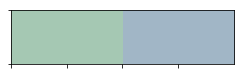

In [12]:
palette = ["#A5C8B3","#A5C8B3", "#A1B6C6","#A1B6C6"]
sns.palplot(sns.color_palette(palette))
plot_order = ['AB+','C+','AC-','B-']
sns.set_context('paper',font_scale = 2)
sns.set_style("white")

In [13]:
#some processing
all_rts['missed_response'] = False
all_rts.loc[all_rts['rew'] == -4, 'missed_response'] = True
all_rts.loc[all_rts['rew'] == -4,'rew'] = 0

all_rts['fn_plus'] = False
all_rts.loc[(all_rts['cond'] == 'b_minus') & (all_rts['target'] == 1),'fn_plus'] = True
all_rts.loc[(all_rts['cond'] == 'c_minus') & (all_rts['target'] == 1),'fn_plus'] = True

all_rts['fp_minus'] = False
all_rts.loc[(all_rts['cond'] == 'b_plus') & (all_rts['target'] == 0),'fn_plus'] = True
all_rts.loc[(all_rts['cond'] == 'c_plus') & (all_rts['target'] == 0),'fn_plus'] = True

stim_map = {'b_plus':'AB+','b_minus':'B-','c_plus':'C+','c_minus':'AC-'}
all_rts['Stimulus'] = [stim_map[x] for x in all_rts['cond']]

for s in ['fd_107','fd_108','fd_109','fd_122']:
    all_rts = all_rts[all_rts['sub'] != s]

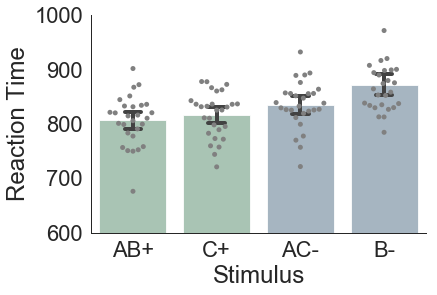

In [14]:
sns.set_context('paper',font_scale = 2.5)
rt = all_rts.dropna(subset = ['rt']).groupby(['Stimulus','sub']).mean().reset_index()
rt = moss.remove_unit_variance(rt, 'rt', 'sub', group=None, suffix="_within")
ax = sns.barplot(x = 'Stimulus', 
                 y = 'rt_within',
                 palette = palette,
                 order = plot_order,
                 capsize=.2,
                 errwidth=4,
                 data = rt)
ax = sns.swarmplot(x = 'Stimulus', 
                   y = 'rt_within', 
                   data = rt, 
                   order = plot_order,
                   color="grey", 
                   edgecolor='white')
ax.set_ylim(600,1000)
sns.despine()
plt.ylabel('Reaction Time')
# plt.savefig('../figs/revision/RT.png',bbox_inches = 'tight', dpi = 300)

In [864]:
rt['Valence'] = 'Negative'
rt.loc[rt['Stimulus'] == 'AB+','Valence'] = 'Positive'
rt.loc[rt['Stimulus'] == 'C+','Valence'] = 'Positive'

rt['StimType'] = 'Pair'
rt.loc[rt['Stimulus'] == 'B-','StimType'] = 'Single'
rt.loc[rt['Stimulus'] == 'C+','StimType'] = 'Single'

rt['logRT'] = np.log(rt['rt'])
model = afex.aov_ez('sub', 'rt', data = rt, within=['StimType','Valence'])
print(model)

Anova Table (Type 3 tests)

Response: rt
            Effect    df     MSE        F  ges p.value
1         StimType 1, 26 1669.24   7.58 *  .02     .01
2          Valence 1, 26 4539.92 12.99 **  .08    .001
3 StimType:Valence 1, 26 1467.38     1.78 .004     .19

Sphericity correction method: GG 



In [30]:
rt['Valence'] = 'Negative'
rt.loc[rt['Stimulus'] == 'AB+','Valence'] = 'Positive'
rt.loc[rt['Stimulus'] == 'C+','Valence'] = 'Positive'

rt['StimType'] = 'Pair'
rt.loc[rt['Stimulus'] == 'B-','StimType'] = 'Single'
rt.loc[rt['Stimulus'] == 'C+','StimType'] = 'Single'

rt['logRT'] = np.log(rt['rt'])
model = afex.aov_ez('sub', 'rt', data = rt, within=['StimType','Valence','epoch'])
print(model)

Anova Table (Type 3 tests)

Response: rt
                  Effect    df     MSE        F    ges p.value
1               StimType 1, 26 3486.52   7.62 *    .02     .01
2                Valence 1, 26 9199.48 12.77 **    .07    .001
3                  epoch 1, 26 1811.74     0.06 <.0001     .81
4       StimType:Valence 1, 26 3032.02     1.62   .003     .21
5         StimType:epoch 1, 26 1904.76     0.14  .0002     .71
6          Valence:epoch 1, 26 1977.21     0.03 <.0001     .86
7 StimType:Valence:epoch 1, 26 2057.72     2.08   .003     .16

Sphericity correction method: GG 



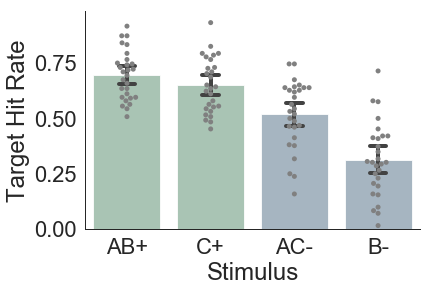

In [16]:
acc = all_rts.groupby(['sub','run','Stimulus']).sum()
acc = acc.reset_index()
acc.loc[acc['Stimulus'] == 'AB+','rew'] =acc.loc[acc['Stimulus'] == 'AB+','rew']/7.0
acc.loc[acc['Stimulus'] == 'AC-','rew'] =acc.loc[acc['Stimulus'] == 'AC-','rew']/3.0
acc.loc[acc['Stimulus'] == 'B-','rew'] =acc.loc[acc['Stimulus'] == 'B-','rew']/3.0
acc.loc[acc['Stimulus'] == 'C+','rew'] =acc.loc[acc['Stimulus'] == 'C+','rew']/7.0
acc = acc.groupby(['sub','Stimulus']).mean().reset_index()
acc = moss.remove_unit_variance(acc, 'rew', 'sub', group=None, suffix="_within")
acc = acc.sort_values(by = 'Stimulus')
ax = sns.swarmplot(x = 'Stimulus', 
                   y = 'rew_within', 
                   data = acc, 
                   order = plot_order,
                   color="grey", 
                   edgecolor='grey')
ax = sns.barplot(x = 'Stimulus', 
                 y = 'rew_within',
                 capsize=.2,
                 errwidth=4,
                  palette = palette,
                 order = plot_order,
                 data = acc)
plt.ylabel('Target Hit Rate')
sns.despine()
plt.savefig('../figs/revision/HitRate.png',bbox_inches = 'tight',dpi = 300)

In [54]:
acc = all_rts.groupby(['sub','run','Stimulus','epoch']).sum()
for row in set(acc.index):
    acc.loc[row, 'hitrate'] = acc.loc[row,'rew'] * 1.0 / acc.loc[row,'target']


In [848]:
acc['Valence'] = 'Negative'
acc.loc[acc['Stimulus'] == 'AB+','Valence'] = 'Positive'
acc.loc[acc['Stimulus'] == 'C+','Valence'] = 'Positive'

acc['StimType'] = 'Pair'
acc.loc[acc['Stimulus'] == 'B-','StimType'] = 'Single'
acc.loc[acc['Stimulus'] == 'C+','StimType'] = 'Single'

model = afex.aov_ez('sub', 'rew', data = acc, within=['StimType','Valence'])
print(model)

Anova Table (Type 3 tests)

Response: rew
            Effect    df  MSE         F ges p.value
1         StimType 1, 27 0.02 26.81 *** .11  <.0001
2          Valence 1, 27 0.04 43.09 *** .35  <.0001
3 StimType:Valence 1, 27 0.02   9.68 ** .05    .004

Sphericity correction method: GG 



In [20]:
##analyze false alarms
from collections import Counter
false_alarms = {'sub':[], 'run':[], 'Stimulus':[],'False Alarms':[]}
for f in full_data:
    if f in subj_list: 
        fa_sim = full_data[f]['fa_sim'].split(',')[:-1]
        trial_step = fa_sim[1::2]
        trial_type = fa_sim[0::2]
        trial_type = [x for n,x in enumerate(trial_type) if trial_step[n] == '3']
        trial_type = np.array([order_dict_sim[int(x)] for x in trial_type])

        for t in ['b_minus','b_plus','c_minus','c_plus']:
            if len(trial_type) == 0:
                fa = 0
            else:
                fa = sum(trial_type == t)
            if t in ['b_minus','c_minus']:
                fa = fa / 7.0
            else:
                fa = fa / 3.0
            false_alarms['sub'].append(f.split('_')[0])
            false_alarms['run'].append(f.split('_')[1])
            false_alarms['False Alarms'].append(fa)
            false_alarms['Stimulus'].append(t)
false_alarms = pd.DataFrame(false_alarms)
false_alarms['Stimulus'] = [stim_map[x] for x in false_alarms['Stimulus']]
false_alarms = false_alarms[false_alarms['sub'] != '122'] #data collection error
false_alarms = false_alarms[~((false_alarms['sub'] == '129') & (false_alarms['run'] == '1'))] #data collection error

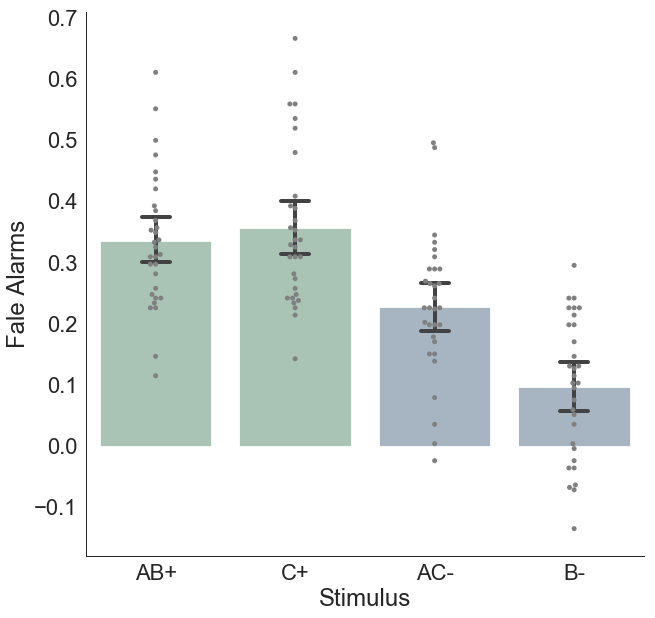

In [52]:
sns.set_context('paper',font_scale = 2.5)
sns.set_style("white")
false_alarms = false_alarms.groupby(['sub','Stimulus']).mean().reset_index()
false_alarms = moss.remove_unit_variance(false_alarms, 'False Alarms', 'sub', group=None, suffix="_within")
ax = sns.barplot(x = 'Stimulus', 
                 y = 'False Alarms_within', 
                 data = false_alarms,
                 order = plot_order,
                 palette = palette,
                 capsize=.2,
                 errwidth=4)
ax = sns.swarmplot(x = 'Stimulus', 
                   y = 'False Alarms_within', 
                   data = false_alarms,
                   color="grey",
                   order = plot_order,
                   edgecolor='grey')
sns.despine()
plt.ylabel('Fale Alarms')
# plt.savefig('../figs/revision/FalseAlarms.png',bbox_inches = 'tight', dpi = 300)

In [852]:
false_alarms['Valence'] = 'Negative'
false_alarms.loc[false_alarms['Stimulus'] == 'AB+','Valence'] = 'Positive'
false_alarms.loc[false_alarms['Stimulus'] == 'C+','Valence'] = 'Positive'

false_alarms['StimType'] = 'Pair'
false_alarms.loc[false_alarms['Stimulus'] == 'B-','StimType'] = 'Single'
false_alarms.loc[false_alarms['Stimulus'] == 'C+','StimType'] = 'Single'

false_alarms['FalseAlarms'] = false_alarms['False Alarms']
model = afex.aov_ez('sub', 'FalseAlarms', data = false_alarms, within=['StimType','Valence'])
print(model)

Anova Table (Type 3 tests)

Response: FalseAlarms
            Effect    df  MSE         F ges p.value
1         StimType 1, 30 0.01   7.94 ** .01    .008
2          Valence 1, 30 0.03 33.69 *** .14  <.0001
3 StimType:Valence 1, 30 0.01 14.83 *** .03   .0006

Sphericity correction method: GG 



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


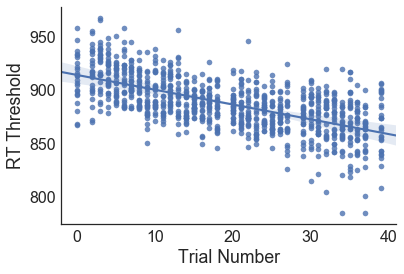

In [806]:
rt = all_rts.dropna(subset = ['rt_thresh'])
rt['trial_index'] = rt['trial_index']/2.0
rt = rt.groupby(['sub','trial_index']).mean().reset_index()
rt = moss.remove_unit_variance(rt, 'rt_thresh', 'sub', group=None, suffix="_within")
sns.regplot(x = 'trial_index', y = 'rt_thresh_within', units = 'sub', data  = rt)
sns.despine()
plt.ylabel('RT Threshold')
plt.xlabel('Trial Number')
plt.savefig('../figs/revision/RT_thresh.svg',dpi = 300)

In [858]:
rt = all_rts.dropna(subset = ['rt'])
rt['trial_index'] = rt['trial_index']/2.0
rt = rt[~rt['fn_plus']]
rt = rt[~rt['fp_minus']]
rt['logRT'] = np.log(rt['rt'])
md = smf.mixedlm("rt ~ trial_index + C(run)", rt, groups=rt["sub"])
md = md.fit()
print md.summary()

           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: rt        
No. Observations:   1114    Method:             REML      
No. Groups:         28      Scale:              18696.4329
Min. group size:    28      Likelihood:         -7082.7045
Max. group size:    42      Converged:          Yes       
Mean group size:    39.8                                  
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    807.431   17.411 46.375 0.000 773.306 841.555
C(run)[T.2]   25.763   10.268  2.509 0.012   5.638  45.888
C(run)[T.3]   19.479   10.228  1.904 0.057  -0.569  39.526
trial_index   -0.792    0.388 -2.043 0.041  -1.552  -0.032
groups RE   5359.082   11.801                             



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
